In [1]:
import numpy as np
import geopandas as gpd


import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

from xhistogram.xarray import histogram
import dask.dataframe as dd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
from mitequinox.plot import *
import mitequinox.parcels as pa
from xmitgcm import llcreader

from fsspec.implementations.local import LocalFileSystem

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.7100733.datarmor0/parcels-502090/libparcels_random_ce6a9e95-fc99-43da-bb45-558f08f8e1df.so


In [2]:
from scipy import signal
import scipy.ndimage as im

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors



In [3]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=15
                 )
#
client = Client(cluster)

In [4]:
isel = dict(face=7)
sel = dict(i=slice(3000,3100), j=slice(3000,3100))#, i_g=slice(3000,3100), j_g=slice(3000,3100)) # North East Hawaii
#sel = dict(i=[3000,3010], j=[3000,3010], i_g=[3000,3010], j_g=[3000,3010]) # North East Hawaii

In [5]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    """
    #x_f = im.convolve1d(x, h, axis=1, mode='constant')
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=0)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [46]:
ds = ut.load_data(["SSU", "SSV"])
grd = ut.load_grd()[['XC', 'YC', 'Depth']].persist()

In [47]:
ds['lon'] = 0*ds.face+grd.XC
ds['lat'] = 0*ds.face+grd.YC
ds = ds.drop(['i_g','j_g']).rename({'i_g':'i','j_g':'j'})#.drop(['i_g','j_g'])
dsi = ds.isel(time=slice(0*24,200*24))

In [48]:
import mitequinox.plot as pl
import mitequinox.sigp as sp

In [49]:
#points = dict(south_atlantic=[7, 3000, 3000],
#              north_pacific=[7, 3050, 3050],
#             )
#_d = xr.DataArray(list(points),dims="point", name="point")
# the line below might be very inefficient
#dsp = xr.concat([dsi.isel(face=i[0], i=i[1], i_g=i[1], j=int(i[2]),j_g=int(i[2])) 
#                 for p, i in points.items()], 
#                dim=_d,
#               )

dsi['zonal_velocity'] = dsi['SSU']*dsi.CS - dsi['SSV']*dsi.SN
dsi['meridional_velocity'] =  dsi['SSU']*dsi.SN + dsi['SSV']*dsi.CS
dsp = dsi.isel(**isel).sel(**sel)

dsp = dsp.chunk({"time": -1}).persist()
dsp

<xarray.Dataset>
Dimensions:              (i: 101, j: 101, time: 4800)
Coordinates:
    face                 int64 7
  * j                    (j) int64 3000 3001 3002 3003 ... 3097 3098 3099 3100
    niter                (time) int64 dask.array<chunksize=(4800,), meta=np.ndarray>
  * time                 (time) datetime64[ns] 2011-11-15 ... 2012-06-01T23:0...
  * i                    (i) int64 3000 3001 3002 3003 ... 3097 3098 3099 3100
    XC                   (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    YC                   (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    Depth                (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    CS                   (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    SN                   (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
    rA                   (j, i) float32 dask.array<chunksize=(101, 101), meta=np.ndarray>
Data variables:
    SSU                  (time, j, i) float32 dask.array<chunksize=(4800, 101, 101), meta=np.ndarray>
    SSV                  (time, j, i) float32 dask.array<chunksize=(4800, 101, 101), meta=np.ndarray>
    lon                  (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    lat                  (j, i) float64 dask.array<chunksize=(101, 101), meta=np.ndarray>
    zonal_velocity       (time, j, i) float32 dask.array<chunksize=(4800, 101, 101), meta=np.ndarray>
    meridional_velocity  (time, j, i) float32 dask.array<chunksize=(4800, 101, 101), meta=np.ndarray>

In [10]:
dt = 1/24 # in days

tidal_omega = sp.get_tidal_frequencies("M2", "K1")
omega, domega, name = tidal_omega["M2"], .2, "semidiurnal"

h = sp.generate_filter(omega, T=10, dt=dt, bandwidth=domega, normalized_bandwidth=None)
h_hat, w = sp.filter_response(h, dt=dt)

No handles with labels found to put in legend.


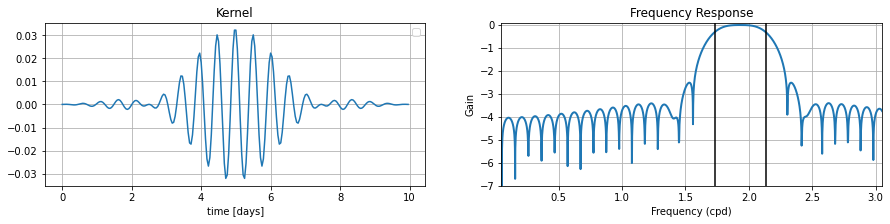

In [11]:
fig, axes = plt.subplots(1,2, figsize=(15,3))
ax = axes[0]
t = np.arange(0, h.size)*dt
ax.plot(t, h)
ax.grid()
ax.set_xlabel('time [days]')
ax.set_title('Kernel')
ax.legend()

ax = axes[1]
ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(omega-domega, color='k')
ax.axvline(omega+domega, color='k')
ax.set_xlabel('Frequency (cpd)')
ax.set_ylabel('Gain')
ax.set_title('Frequency Response')
#ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

#### Band passed (no Hilbert transform)

In [12]:
for v in ['zonal_velocity','meridional_velocity']:
    dsp[v+"_hat"] = filt(dsp[v], h,hilbert=False
                        )
#dsp = ds.persist()

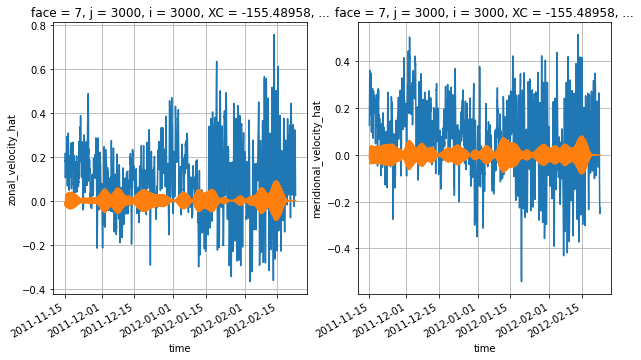

In [13]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    dsp[v].isel(i=0,j=0).plot(ax=ax)
    dsp[v+'_hat'].isel(i=0,j=0).plot(ax=ax)
    ax.grid()

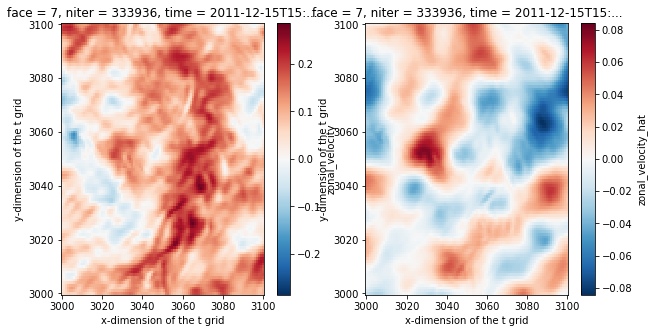

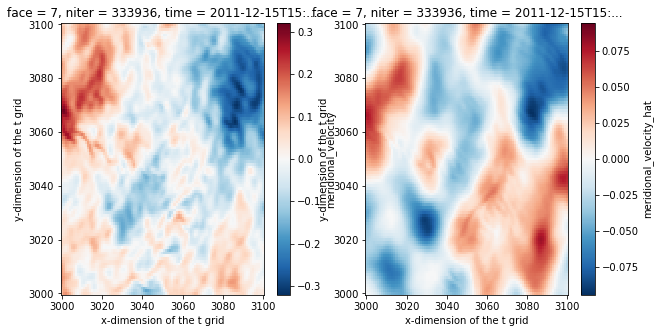

In [15]:
it = 15
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    dsp[v+'_hat'].isel(time=it).plot(ax=ax[1])
    dsp[v].isel(time=it).plot(ax=ax[0])#,x='lon',y='lat'

In [14]:
for v in ['zonal_velocity','meridional_velocity']:
    dsp[v+"_hat"] = filt(dsp[v], h,hilbert=True
                        )

In [16]:
dsp = dsp.persist()

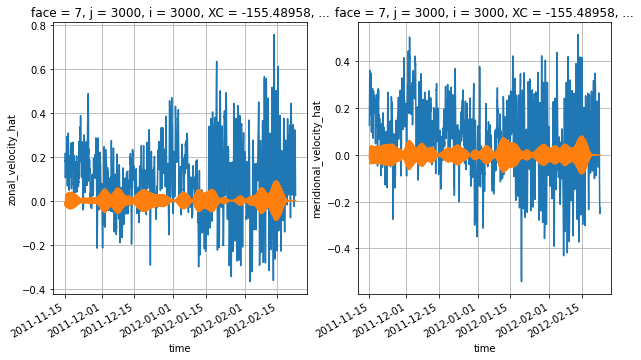

In [17]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    dsp[v].isel(i=0,j=0).plot(ax=ax)
    np.real(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    ax.grid()

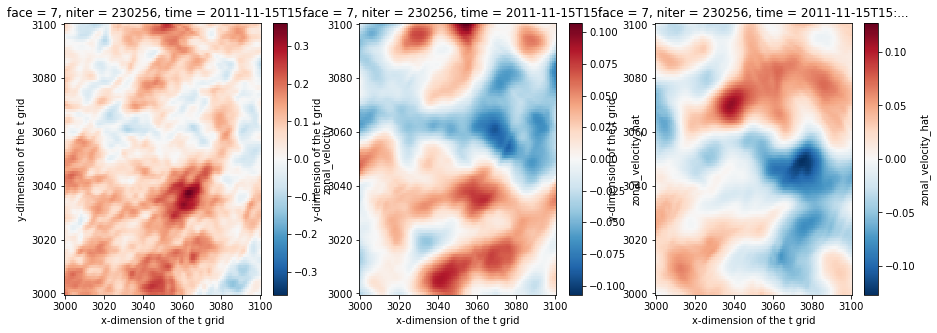

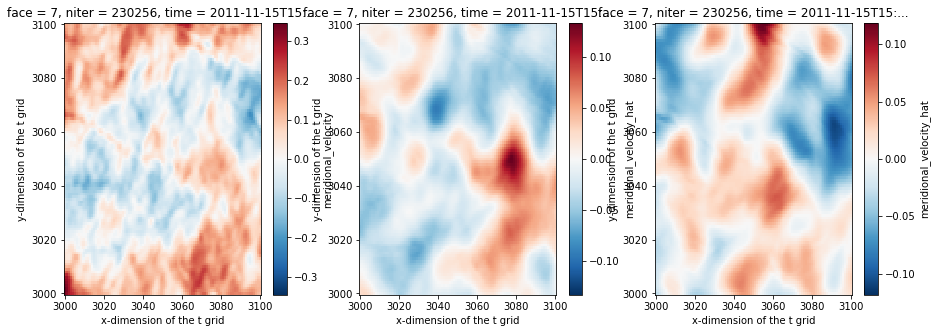

In [18]:
it = 15
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    np.real(dsp[v+'_hat']).isel(time=it).plot(ax=ax[1])
    np.imag(dsp[v+'_hat']).isel(time=it).plot(ax=ax[2])
    dsp[v].isel(time=it).plot(ax=ax[0])#,x='lon',y='lat'

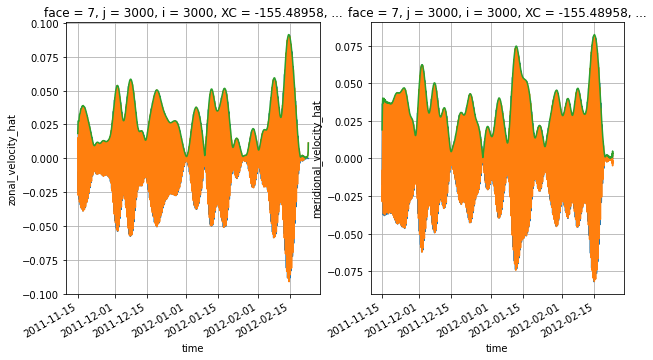

In [19]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    #dsp[v].isel(i=0,j=0).plot(ax=ax)
    np.real(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    np.imag(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    np.abs(dsp[v+'_hat']).isel(i=0,j=0).plot(ax=ax)
    ax.grid()

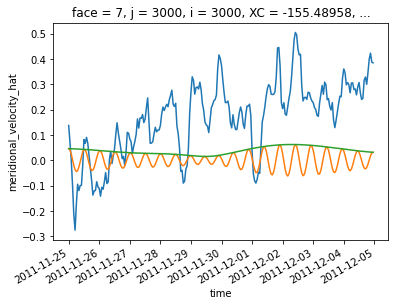

In [20]:
dsp[v].isel(time=slice(24*10,24*20),i=0,j=0).plot()
np.real(dsp[v+'_hat']).isel(time=slice(24*10,24*20),i=0,j=0).plot()
np.abs(dsp[v+'_hat']).isel(time=slice(24*10,24*20),i=0,j=0).plot()

In [21]:
test_autocorr = dsp['meridional_velocity_hat'].compute()

In [22]:
test_autocorr

<xarray.DataArray 'meridional_velocity_hat' (j: 101, i: 101, time: 2400)>
array([[[-1.72026504e-02-8.05566203e-03j,
         -5.56531391e-04-2.87516002e-02j,
          1.65479811e-02-2.37818512e-02j, ...,
          4.89062102e-06-1.16856985e-03j,
          4.20155218e-06-4.91450789e-03j,
          4.07767961e-06+3.40517319e-03j],
        [-1.40694652e-02-9.58224513e-03j,
          2.42019343e-03-2.74317726e-02j,
          1.86728289e-02-2.14989766e-02j, ...,
          5.10035710e-06-1.77165582e-03j,
          4.54065458e-06-5.26584591e-03j,
          4.44570090e-06+1.40780205e-03j],
        [-8.80427451e-03-1.08474015e-02j,
          6.17606390e-03-2.35066429e-02j,
          2.00017422e-02-1.67580531e-02j, ...,
          5.10579854e-06-2.43091474e-03j,
          4.67510130e-06-5.31548325e-03j,
          4.60787314e-06-1.34991836e-03j],
        ...,
        [ 9.84230257e-03+3.29212640e-03j,
...
         -4.61886372e-06+9.70261545e-03j],
        ...,
        [-1.81852448e-02+1.58536682e-02j,
         -2.41244956e-02+1.30333827e-03j,
         -2.41318065e-02-8.98215167e-03j, ...,
         -9.51780863e-06+5.39363115e-03j,
         -8.05979186e-06+4.95338038e-03j,
         -7.79217233e-06+1.47674858e-02j],
        [-1.62142010e-02+1.47786331e-02j,
         -2.21536700e-02+2.01236678e-03j,
         -2.26841253e-02-7.58744700e-03j, ...,
         -9.05857643e-06+4.97504483e-03j,
         -7.63775619e-06+4.67590347e-03j,
         -7.37605630e-06+1.34535192e-02j],
        [-1.57384691e-02+1.46634928e-02j,
         -2.18159613e-02+2.38129023e-03j,
         -2.26023540e-02-7.13457339e-03j, ...,
         -8.63069394e-06+4.91229196e-03j,
         -7.31262119e-06+4.66742792e-03j,
         -7.07067778e-06+1.32029014e-02j]]])
Coordinates:
    face     int64 7
  * j        (j) int64 3000 3001 3002 3003 3004 ... 3096 3097 3098 3099 3100
    niter    (time) int64 228096 228240 228384 228528 ... 573264 573408 573552
  * time     (time) datetime64[ns] 2011-11-15 ... 2012-02-22T23:00:00
  * i        (i) int64 3000 3001 3002 3003 3004 ... 3096 3097 3098 3099 3100
    XC       (j, i) float32 -155.5 -155.5 -155.5 -155.5 ... -153.4 -153.4 -153.4
    YC       (j, i) float32 36.43 36.42 36.4 36.38 ... 34.92 34.9 34.88 34.87
    Depth    (j, i) float32 5.682e+03 5.682e+03 ... 5.682e+03 5.677e+03
    CS       (j, i) float32 2.12e-13 2.119e-13 ... -6.236e-13 -4.157e-13
    SN       (j, i) float32 -1.0 -1.0 -1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0 -1.0
    rA       (j, i) float32 3.206e+06 3.207e+06 3.209e+06 ... 3.329e+06 3.33e+06

In [53]:
i=0
C=[]
Nr = 20*24
overlap=0.5
v1,v2 = np.abs(test_autocorr.isel(i=0,j=0)),np.abs(test_autocorr.isel(i=0,j=0))
kwargs = {'mode': 'valid'}
while i+Nr<v1.size:
    _v1 = v1[i:i+Nr]
    _v2 = v2[i:i+Nr]
    C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
    i+=int((1-overlap)*Nr)
#np.mean(np.stack(C), axis=0)

In [57]:
corr = np.mean(np.stack(C), axis=0)/np.mean(np.stack(C), axis=0)[0]

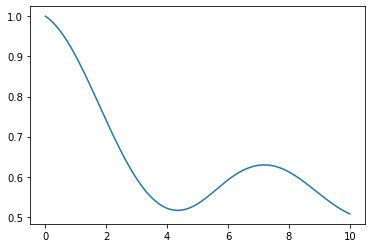

In [58]:
tau = np.arange(0,(Nr//2)/24+1/24,1/24)
plt.plot(tau[:],corr)

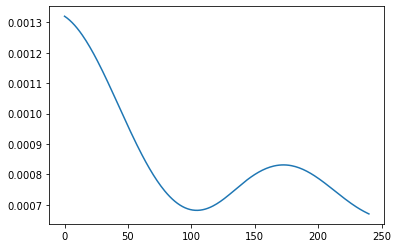

In [65]:
plt.plot(correlate_E(v1,v2,dt=1,roll=False,detrend=False,Nr=Nr))

In [23]:
# Definition of the functions to compute the correlation
def correlate_E(v1, v2, dt=None, roll=False, detrend=True, ufunc=True,**kwargs):
    ''' Compute a lagged correlation between two time series
    These time series are assumed to be regularly sampled in time 
    and along the same time line.
    
    Parameters
    ----------
    
        v1, v2: ndarray, pd.Series
            Time series to correlate, the index must be time if dt is not provided
            
        dt: float, optional
            Time step
            
        detrend: boolean, optional
            Turns detrending on or off. Default is False.

    See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.correlate.html
    '''
    
    assert v1.shape == v2.shape
    
    if not ufunc:
        v1 = v1.transpose((2,1,0))
        v2 = v2.transpose((2,1,0))
    
    if detrend and not roll:
        v1 = signal.detrend(v1)
        v2 = signal.detrend(v2)
        _correlate = np.correlate
        _kwargs = {'mode': 'valid'}
        N = int(v1.shape[-1]/2)
    else:
        _correlate = roll_correlate
        _kwargs = {'mode': 'valid','detrend':detrend}
    _kwargs.update(**kwargs)
    
    # loop over all dimensions but the last one to apply correlate
    Ni = v1.shape[:-1]
    # infer number of lags from dummy computation
    i0 = tuple(0 for i in Ni) + np.s_[:,]
    f = _correlate(v1[i0], v2[i0], **_kwargs)
    vv = np.full(Ni+f.shape, np.NaN)
    for ii in np.ndindex(Ni):
        f = _correlate(v1[ii + np.s_[:,]], v2[ii + np.s_[:,]], **_kwargs)
        Nj = f.shape
        for jj in np.ndindex(Nj):
            vv[ii + jj] = f[jj]
    
    # select only positive lags
    #vv = vv[...,:]
    
    if ufunc:
        return vv
    else:
        lags = np.arange(vv.shape[-1])*dt
        vv = vv.transpose((2,1,0))
        return lags, vv

def roll_correlate(v1, v2, Nr=None, overlap=0.5, detrend=True, **kwargs):
    ''' Correlation over temporal windows of size Nr with overlap
    '''
    i=0
    C=[]
    while i+Nr<v1.size:
        _v1 = v1[i:i+Nr]
        _v2 = v2[i:i+Nr]
        if detrend:
            _v1 = signal.detrend(_v1)
            _v2 = signal.detrend(_v2)
        C+=[np.correlate(_v1[Nr//2:], _v2, **kwargs)/(Nr/2)]
        i+=int((1-overlap)*Nr)
    return np.mean(np.stack(C), axis=0)
    
# quick tests
#v1 = ds.u.isel(x_u=slice(0,10), y_rho=slice(0,10)).values.transpose((1,2,0))
#v1_cor = correlate(v1, v1, dt=1/24/6)
#v1_cor = roll_correlate(v1[0,0,:], v1[0,0,:], Nr=6*24*20, overlap=0)
#v1_cor = correlate(v1, v1, roll=True, Nr=6*24*20, overlap=0)

In [24]:
# Wrapping function
def wrap_correlate(v1, v2, dt, lags=None, **kwargs):
    v1 = v1.chunk({'time': -1})
    v2 = v2.chunk({'time': -1})
    if lags is None:
        lags, C = correlate_E(v1.values, v2.values, dt=dt, ufunc=False, **kwargs)
        return lags, C
    else:
        C = xr.apply_ufunc(correlate_E, v1, v2,
                    dask='parallelized', output_dtypes=[np.float64],
                    input_core_dims=[['time'], ['time']],
                    output_core_dims=[['lags']],
                    output_sizes={'lags': lags.size}, kwargs=kwargs)
        return C.assign_coords(lags=lags).rename('correlation')

In [39]:
T = 20 #time window size (size of th segments)
dt = 1/24#float((ds.time[1]-ds.time[0]).values) # time step
binsize = 50 # binsize over which the correlation will be averaged
#_u = np.abs(test_autocorr.isel(i=slice(0,2),j=slice(0,2)))#ds.v.isel(x_rho=slice(0,2),y_rho=slice(0,2))
#lags, _ = wrap_correlate(_u, _u, dt, roll=True, Nr=int(T/dt),detrend=False) #initialization of the lags (used as input)

In [40]:
# Autocorrelation of v`
lags = np.arange(0,T//2+dt,dt)
Cvv = wrap_correlate(np.abs(test_autocorr), np.abs(test_autocorr),dt, lags=lags, roll=True,detrend=False, Nr=int(T/dt))#.persist()

<ipython-input-24-82a075f8273b>:9: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  C = xr.apply_ufunc(correlate_E, v1, v2,


In [41]:
tst = Cvv.isel(i=0,j=0).compute()#.plot()

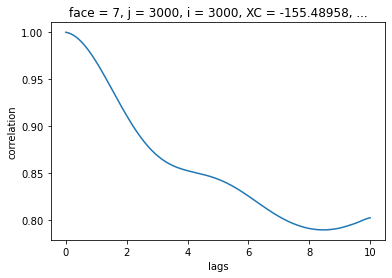

In [42]:
(tst/tst.isel(lags=0)).plot()

In [43]:
Cvv_mean = Cvv.mean(['i','j']).compute()

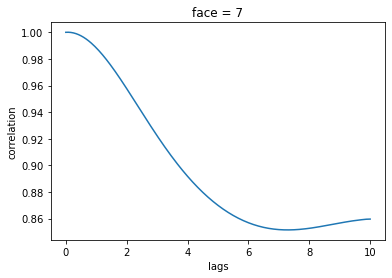

In [44]:
(Cvv_mean/Cvv_mean.isel(lags=0)).plot()

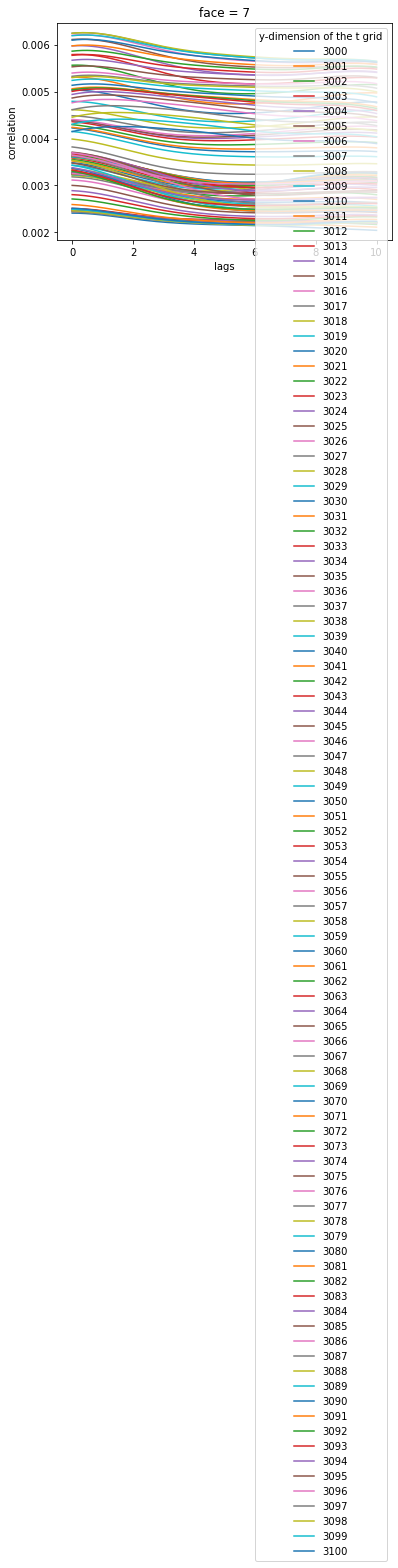

In [133]:
#Cvv_mean.plot.line(hue='j')

### Lagrangian

In [25]:
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'
parcels_index = 'time_mean'

# choose to select time indexed data for now
p = pa.parcels_output(root_dir+run_name, parquets=[parcels_index])
df = p[parcels_index]
df = pa.degs2ms(df)
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,Eta_interp,SSU_interp,SST_interp,SSV_interp,SSS_interp
time,,,,,,,,,,,,,,
2011-11-15,39000000,57.835732,-178.867081,0.0,0.0,0.0,0.0,0.0,0.0,0.060997,-0.002461,4.279537,-0.006017,33.194778
2011-11-15,39000001,58.429878,-178.871994,0.0,0.0,0.0,0.0,0.0,0.0,0.075155,-0.091730,4.326020,0.050204,33.139637
2011-11-15,39000002,59.018066,-178.879623,0.0,0.0,0.0,0.0,0.0,0.0,0.169278,-0.203138,4.161501,0.209887,32.961617
2011-11-15,39000003,59.600288,-178.890015,0.0,0.0,0.0,0.0,0.0,0.0,0.242839,-0.075768,3.679666,0.064889,32.712219
2011-11-15,39000004,60.176525,-178.903275,0.0,0.0,0.0,0.0,0.0,0.0,0.222071,-0.006189,3.151162,0.057710,32.573410


In [28]:
lonmin,lonmax,latmin,latmax = dsp.lon.min().values,dsp.lon.max().values,dsp.lat.min().values,dsp.lat.max().values

In [29]:
# extract relevant trajectory indices
bbox=[lonmin,lonmax,latmin,latmax]
_df = df[ (df.lon>=bbox[0])
        &(df.lon<=bbox[1])
        &(df.lat>=bbox[2])
        &(df.lat<=bbox[3])
       ]
traj = _df.drop_duplicates(subset=["trajectory"]).compute()["trajectory"]
df_selected = df[df.trajectory.isin(traj)]

In [61]:
lon,lat = df_selected.lon.values.compute(),df_selected.lat.values.compute()
df_zon_vel = df_selected.zonal_velocity.values.compute()

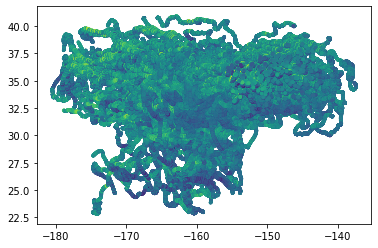

In [63]:
plt.scatter(lon,lat,c=df_zon_vel,s=6)

In [115]:
#df_selected[df_selected.index.values==dsp.time.values]
#df_selected[dsp.time.values[0]].index.values.compute()
#df_selected.loc[dsp.time.values[0]:dsp.time.values[-1]]#.index.values.compute()
i=traj[10:15]
dfi = df_selected[df_selected.trajectory.isin(i)]

In [130]:
#dfi = dfi.compute()
dfi = dfi.drop_duplicates()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


<AxesSubplot:xlabel='lon', ylabel='lat'>

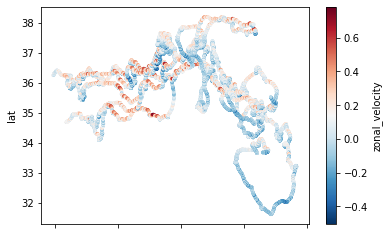

In [131]:
dfi.plot.scatter(x='lon',y='lat',c='zonal_velocity',s=5,cmap='RdBu_r')
#plt.scatter(dfi.lon.values.compute(),dfi.lat.values.compute(),s=6,c=time)

In [135]:
dfi = dfi.loc[dsp.time.values[0]:dsp.time.values[-1]]


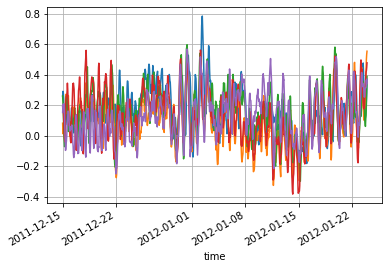

In [150]:
for ii in i:
    dfi[dfi.trajectory==ii].zonal_velocity.plot.line()
plt.grid()

In [204]:
def filt_L(v, h,columns, hilbert=False):
    vc = v.copy()
    for V in columns:
        vc[V+'_hat'] = convolve(v[V],h,hilbert=hilbert)
    
    #output_dtype = complex if hilbert else float
    #gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return vc#xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
            #        dask='parallelized', output_dtypes=[output_dtype],
            #       input_core_dims=[['time']],
            #        output_core_dims=[['time']],
            #       dask_gufunc_kwargs = gufunc_kwargs,
            #            )

In [207]:
test_filter = dfi.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'])

In [208]:

test_filter = test_filter.drop(columns=['trajectory'])

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

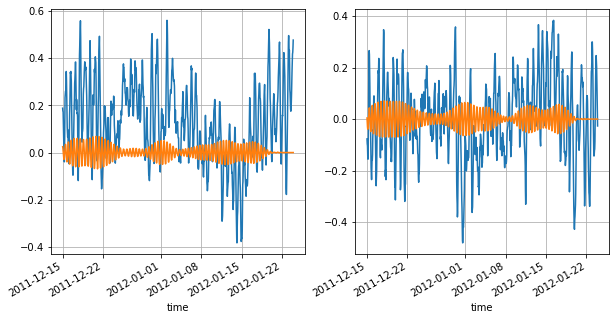

In [217]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    test_filter.loc[(37000467)][v].plot(ax=ax)
    test_filter.loc[(37000467)][v+'_hat'].plot(ax=ax)
    ax.grid()

In [228]:
test_filter.lon.max()

-149.6181160426082

In [234]:
test_filter['lon'] = (test_filter['lon']+180)%360 - 180
lon_bins = np.arange(test_filter.lon.min(),test_filter.lon.max(),0.5)
lat_bins = np.arange(test_filter.lat.min(),test_filter.lat.max(),0.5)
test_filter['lon_cut'] = pd.cut(test_filter['lon'],bins=lon_bins)#.map_partitions(pd.cut, lon_bins)
test_filter['lat_cut'] = pd.cut(test_filter['lat'],bins=lat_bins)#.map_partitions(pd.cut, lat_bins)

In [238]:
filter_mean = test_filter.groupby(['lon_cut','lat_cut']).mean()#.zonal_velocity.plot(x='lon_cut',y='lat_cut')
filter_mean = pa.add_geodata(filter_mean)

In [239]:
filter_mean

lat      lon    z  zonal_velocity  \
lon_cut              lat_cut                                                  
(-157.841, -157.341] (34.532, 35.032]  34.782 -157.591  NaN             NaN   
                     (35.032, 35.532]  35.282 -157.591  NaN             NaN   
                     (35.532, 36.032]  35.782 -157.591  0.0        0.081480   
                     (36.032, 36.532]  36.282 -157.591  0.0        0.159681   
(-157.341, -156.841] (34.532, 35.032]  34.782 -157.091  NaN             NaN   
...                                       ...      ...  ...             ...   
(-150.841, -150.341] (36.032, 36.532]  36.282 -150.591  0.0        0.094531   
(-150.341, -149.841] (34.532, 35.032]  34.782 -150.091  NaN             NaN   
                     (35.032, 35.532]  35.282 -150.091  NaN             NaN   
                     (35.532, 36.032]  35.782 -150.091  NaN             NaN   
                     (36.032, 36.532]  36.282 -150.091  0.0        0.164541   

                                       meridional_velocity  sea_level  \
lon_cut              lat_cut                                            
(-157.841, -157.341] (34.532, 35.032]                  NaN        NaN   
                     (35.032, 35.532]                  NaN        NaN   
                     (35.532, 36.032]            -0.040721   0.426837   
                     (36.032, 36.532]             0.001622   0.387023   
(-157.341, -156.841] (34.532, 35.032]                  NaN        NaN   
...                                                    ...        ...   
(-150.841, -150.341] (36.032, 36.532]             0.124525   0.544620   
(-150.341, -149.841] (34.532, 35.032]                  NaN        NaN   
                     (35.032, 35.532]                  NaN        NaN   
                     (35.532, 36.032]                  NaN        NaN   
                     (36.032, 36.532]            -0.000210   0.507341   

                                       temperature   salinity  Eta_interp  \
lon_cut              lat_cut                                                
(-157.841, -157.341] (34.532, 35.032]          NaN        NaN         NaN   
                     (35.032, 35.532]          NaN        NaN         NaN   
                     (35.532, 36.032]    17.499762  34.150208    0.464923   
                     (36.032, 36.532]    16.744951  33.962761    0.448487   
(-157.341, -156.841] (34.532, 35.032]          NaN        NaN         NaN   
...                                            ...        ...         ...   
(-150.841, -150.341] (36.032, 36.532]    15.558521  33.512012    0.442265   
(-150.341, -149.841] (34.532, 35.032]          NaN        NaN         NaN   
                     (35.032, 35.532]          NaN        NaN         NaN   
                     (35.532, 36.032]          NaN        NaN         NaN   
                     (36.032, 36.532]    16.046665  33.878105    0.444354   

                                       SSU_interp  SST_interp  SSV_interp  \
lon_cut              lat_cut                                                
(-157.841, -157.341] (34.532, 35.032]         NaN         NaN         NaN   
                     (35.032, 35.532]         NaN         NaN         NaN   
                     (35.532, 36.032]    0.075283   18.247656   -0.000156   
                     (36.032, 36.532]    0.124407   17.908087    0.000730   
(-157.341, -156.841] (34.532, 35.032]         NaN         NaN         NaN   
...                                           ...         ...         ...   
(-150.841, -150.341] (36.032, 36.532]    0.084565   18.265819    0.011651   
(-150.341, -149.841] (34.532, 35.032]         NaN         NaN         NaN   
                     (35.032, 35.532]         NaN         NaN         NaN   
                     (35.532, 36.032]         NaN         NaN         NaN   
                     (36.032, 36.532]    0.091285   18.213238    0.027842   

                                       SSS_interp  zonal_vel

In [241]:
#means = pa.add_geodata(means)
#count['density'] = count['count']/count['area']

ds_mean = (filter_mean
     # .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

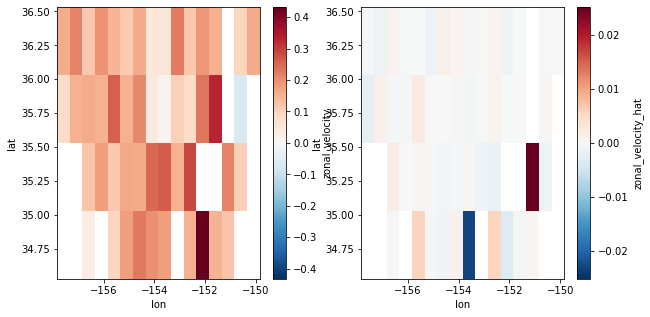

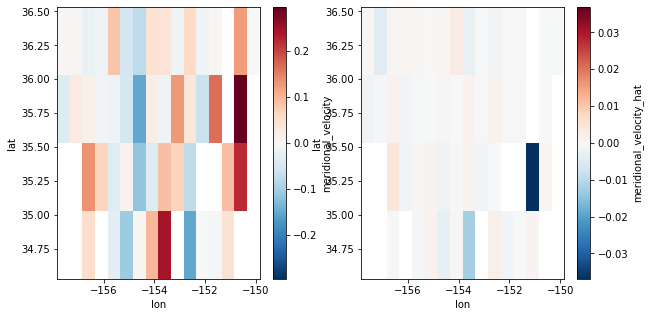

In [246]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_mean[v].plot(y='lat',ax=ax[0])
    ds_mean[v+'_hat'].plot(y='lat',ax=ax[1])

In [248]:
df_selected = df_selected.drop_duplicates()
df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'])

<ipython-input-248-712549c4162a>:2: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_filtered = df_selected.groupby('trajectory').apply(filt_L,h,['zonal_velocity','meridional_velocity'])


In [249]:
df_filtered = df_filtered.persist()

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

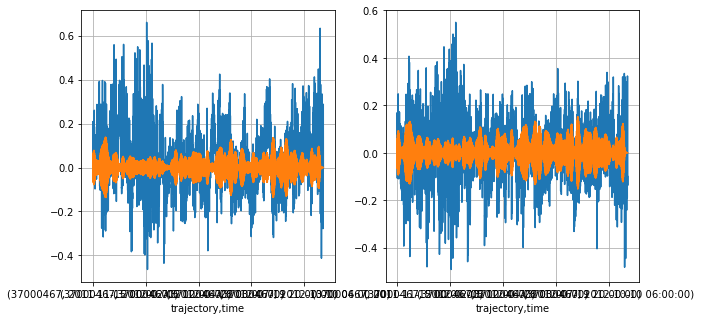

In [255]:
df_test = df_filtered.loc[(37000467)].compute()
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    df_test[v].plot(ax=ax)
    df_test[v+'_hat'].plot(ax=ax)
    ax.grid()

In [277]:
df_test = df_test.drop(columns='trajectory').reset_index().set_index('time')

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():
/home1/datahome/zcaspar/m

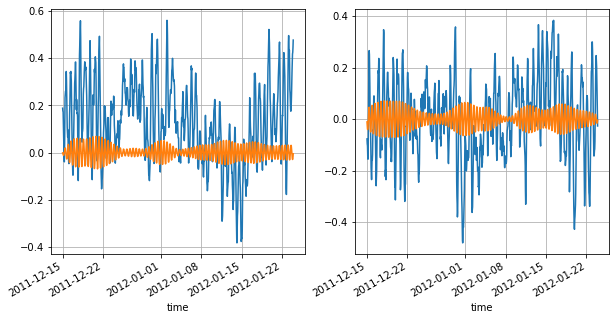

In [279]:
fig,axs = plt.subplots(1,2,figsize=(10,5))
for v ,ax in zip(['zonal_velocity','meridional_velocity'],axs):
    df_test.loc[dsp.time.values[0]:dsp.time.values[-1]][v].plot(ax=ax)
    df_test.loc[dsp.time.values[0]:dsp.time.values[-1]][v+'_hat'].plot(ax=ax)
    ax.grid()

In [258]:
df_filtered['lon'] = (df_filtered['lon']+180)%360 - 180
lon_bins = np.arange(df_filtered.lon.min().compute(),df_filtered.lon.max().compute(),0.5)
lat_bins = np.arange(df_filtered.lat.min().compute(),df_filtered.lat.max().compute(),0.5)
df_filtered['lon_cut'] = df_filtered['lon'].map_partitions(pd.cut, lon_bins)
df_filtered['lat_cut'] = df_filtered['lat'].map_partitions(pd.cut, lat_bins)

In [259]:
filter_mean = df_filtered.groupby(['lon_cut','lat_cut']).mean().compute()
filter_mean = pa.add_geodata(filter_mean)

In [260]:
ds_mean = (filter_mean
     # .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
     .to_xarray()
    )

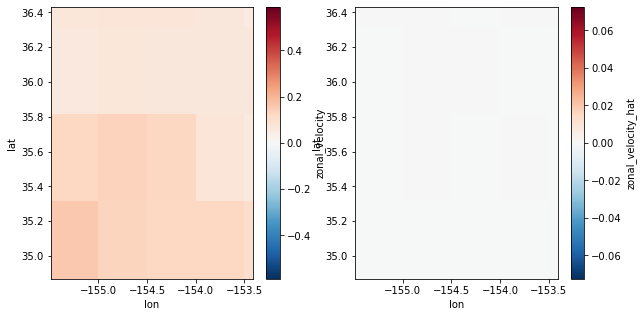

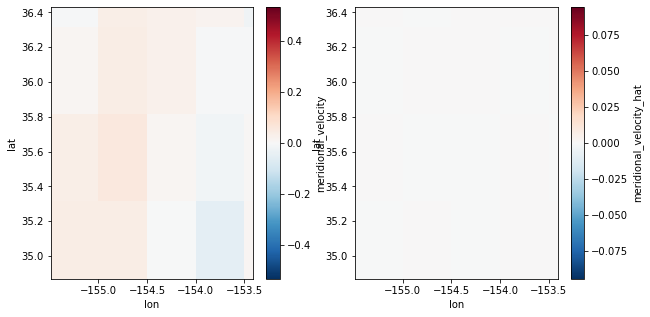

In [268]:
for v in ['zonal_velocity','meridional_velocity']:
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    ds_mean[v].plot(y='lat',ax=ax[0])
    ds_mean[v+'_hat'].plot(y='lat',ax=ax[1])
    ax[0].set_ylim(dsp.lat.min(),dsp.lat.max())
    ax[0].set_xlim(dsp.lon.min(),dsp.lon.max())
    ax[1].set_ylim(dsp.lat.min(),dsp.lat.max())
    ax[1].set_xlim(dsp.lon.min(),dsp.lon.max())

In [50]:
cluster.close()

distributed.core - ERROR - 'tcp://10.148.0.31:50090'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 573, in handle_stream
    handler(**merge(extra, msg))
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 5018, in handle_release_data
    ws: WorkerState = parent._workers_dv[worker]
KeyError: 'tcp://10.148.0.31:50090'
distributed.utils - ERROR - 'tcp://10.148.0.31:50090'
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/utils.py", line 668, in log_errors
    yield
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 4032, in add_worker
    await self.handle_worker(comm=comm, worker=address)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/schedule